In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/0r/j22hntp103nbknzwp2b4l7rh0000gn/T/ipykernel_2811/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {most_recent_date}")


Most recent date: 2017-08-23


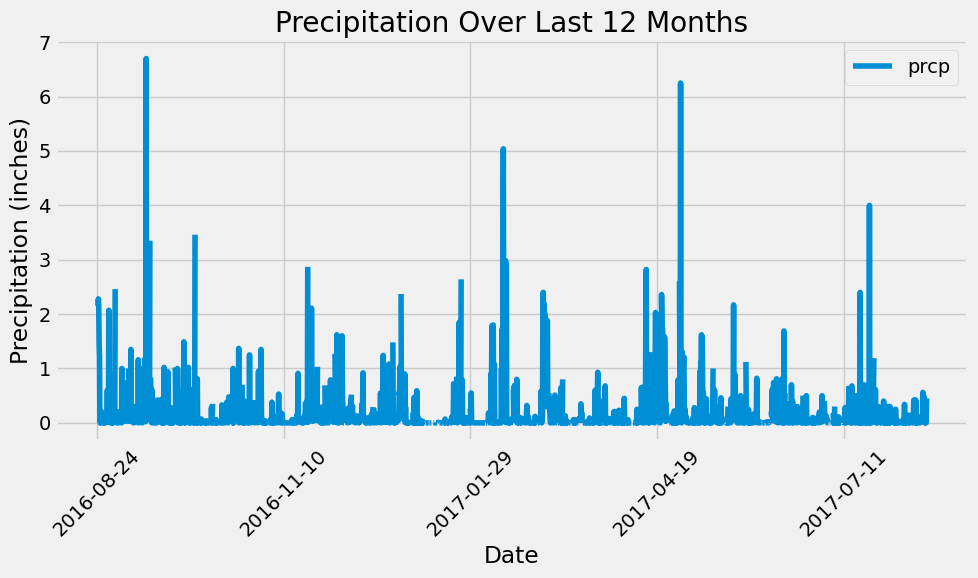

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                     filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="date", y="prcp", figsize=(10, 6), title="Precipitation Over Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order
print(f"Most active stations: {active_stations}")

# Find the station ID with the greatest number of observations
most_active_station_id = active_stations[0][0]
print(f"Most active station ID: {most_active_station_id}")

Most active stations: [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
Most active station ID: USC00519281


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.avg(Measurement.tobs), 
    func.max(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

print(f"Temperature stats for the most active station: {temperature_stats}")


Temperature stats for the most active station: [(54.0, 71.66378066378067, 85.0)]


         date  tobs
0  2016-08-24  77.0
1  2016-08-25  80.0
2  2016-08-26  80.0
3  2016-08-27  75.0
4  2016-08-28  73.0


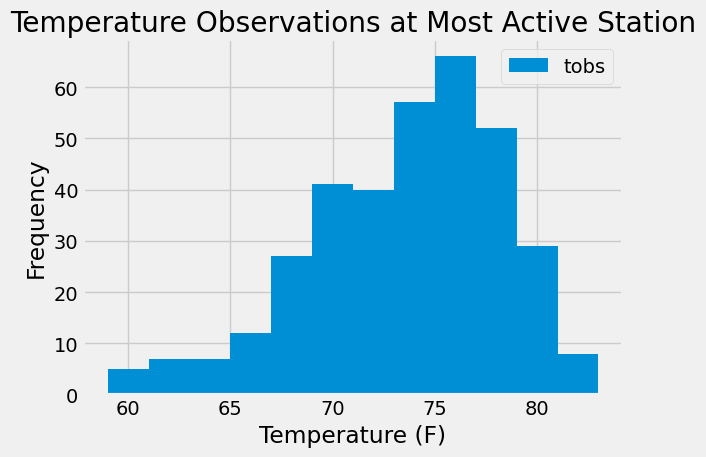

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == most_active_station_id).\
            filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["date", "tobs"])

# Verify the DataFrame
print(tobs_df.head())

# Plot the results as a histogram
tobs_df.plot.hist(bins=12, title="Temperature Observations at Most Active Station")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()